In [16]:
#conda install opencv 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\crahu\anaconda3\envs\CRV

  added / updated specs:
    - opencv


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    freeglut-3.2.2             |       h0e60522_1         150 KB  conda-forge
    intel-openmp-2022.0.0      |    h57928b3_3663         3.6 MB  conda-forge
    jpeg-9e                    |       h8ffe710_0         373 KB  conda-forge
    libblas-3.9.0              |     13_win64_mkl         5.3 MB  conda-forge
    libcblas-3.9.0             |     13_win64_mkl         5.3 MB  conda-forge
    libdeflate-1.10            |       h8ffe710_0          69 KB  conda-forge
    liblapack-3.9.0            |     13_win64_mkl         5.3 MB  conda-forge
    liblapacke-3.9.0           |     13_win64_mkl         5.3 MB  conda-forge
    libopencv-4.5.5            |   py37h04cf790_3        47.5 MB  conda-



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
#tesor fow & keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2     
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#cnn
from tensorflow.keras import datasets, layers, models

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
seed = 42
np.random.seed =seed

In [4]:
import zipfile

with zipfile.ZipFile("C:/Users/crahu/Downloads/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("C:/Users/crahu/Downloads/test1.zip","r") as z:
    z.extractall(".")

In [23]:
image_path = "C:/Users/crahu/Documents"

In [6]:
def get_Label(number):
    labels = {0:'Cat', 1:'Dog'}
    return labels[number]


#plot predction function
def plot_predection(model_name):
    plt.figure(figsize=(20,15))
    plt.suptitle("Predection  Images", fontsize=20)
    images = [] 
    path =image_path+'/'+'test1/'
    count = 0  #val_images,val_labels
    for i,files in enumerate(os.listdir(path)) :
        img = plt.imread(path+files)
        img = cv2.resize(img,(128,128))
        plt.imshow(img,cmap=plt.cm.binary)
        img = np.expand_dims(img, axis=0)
        feature = model_name.predict(img)
        predection  = np.argmax(feature, axis=1)
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel("Predicted"+get_Label(int(predection)))
        count += 1
        if count == 34 :
            break    

In [8]:
all_categories = []
images = os.listdir("C:/Users/crahu/Documents/train")
for file in images:
    if file.split('.')[0] == 'dog':
        all_categories.append(1)
    else:
        all_categories.append(0)
#creat data fram to save each image with its label 
df =pd.DataFrame({
    'image': images,
    'category':all_categories
})

df.head(5)

,image,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [9]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

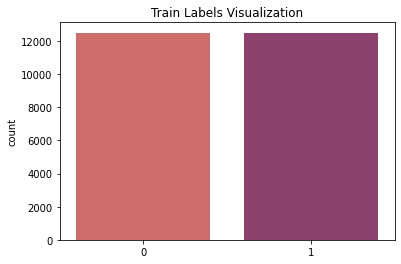

In [10]:
plt.title('Train Labels Visualization')
sns.countplot(x=all_categories,palette='flare')
plt.show()

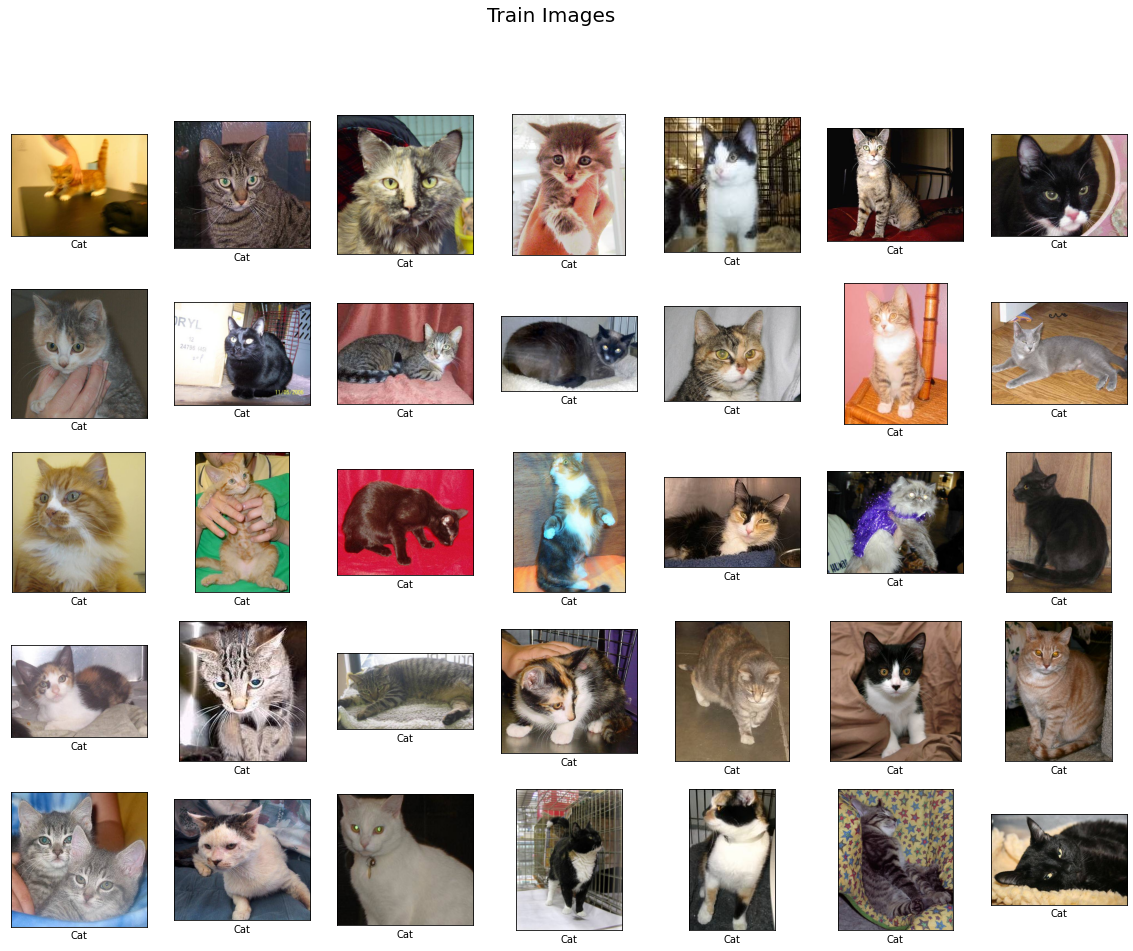

In [13]:
plt.figure(figsize=(20,15))
plt.suptitle("Train Images", fontsize=20)
path ="C:/Users/crahu/Documents/train/"
counter =0
for i,img in enumerate(os.listdir(path))  :
        plt.subplot(5,7,i+1)
        full_image= plt.imread(path+img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(get_Label(all_categories[i]))
        plt.imshow(full_image, cmap=plt.cm.binary) 
        if i == 34:
            break

In [14]:
df['category'] = df['category'].replace({1:'dog',0:'cat'})
df.head(10)

,image,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
5,cat.10000.jpg,cat
6,cat.10001.jpg,cat
7,cat.10002.jpg,cat
8,cat.10003.jpg,cat
9,cat.10004.jpg,cat


In [15]:
df['category'].value_counts()

cat    12500
dog    12500
Name: category, dtype: int64

In [16]:
x_train,x_val  = train_test_split(df ,random_state=42,shuffle=True,test_size=0.2)

In [17]:
x_train['category'].value_counts()

dog    10015
cat     9985
Name: category, dtype: int64

In [18]:
x_val['category'].value_counts()

cat    2515
dog    2485
Name: category, dtype: int64

In [19]:
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)

In [20]:
print('Train Images shape is        : ',x_train.shape)
print('Validation  Images  shape is : ',x_val.shape)

Train Images shape is        :  (20000, 2)
Validation  Images  shape is :  (5000, 2)


In [24]:
batch_size = 64
#create image generator for images 
image_gen = ImageDataGenerator(
                                 rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20, 
                            
                               )

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(  
                                   rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20,)

        
train = image_gen.flow_from_dataframe(
      x_train,
      image_path+'/'+'train/',
      x_col='image',
      y_col='category',
      target_size=(128,128),
      class_mode='categorical',
      shuffle=True, 
      batch_size=batch_size
      )
validate = test_data_gen.flow_from_dataframe(
      x_val,
      image_path+'/'+'train/',
      x_col='image',
      y_col='category',
      target_size=(128,128),
      class_mode='categorical',
      shuffle=True, 
      batch_size=batch_size
      )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [25]:
for train_img , train_label in train :
    print('image shape ',train_img.shape)
    print('label  shape ',train_label.shape)
    break 

image shape  (64, 128, 128, 3)
label  shape  (64, 2)


In [26]:
for v_img , v_label in validate :
    print('image shape ',v_img.shape)
    print('label  shape ',v_label.shape)
    break 

image shape  (64, 128, 128, 3)
label  shape  (64, 2)


In [27]:
cnn_model = Sequential()
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64,(3,3),padding ='Same',activation = 'relu',input_shape=(128,128,3)))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(128,(3,3),padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(128,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(256,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(BatchNormalization())
cnn_model.add(layers.Conv2D(256,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(BatchNormalization())
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)     

In [28]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(1024, activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.7))
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(2, activation ='softmax'))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)     

In [31]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [33]:
n_training_samples = len(train)
n_validation_samples = len(validate)
history = cnn_model.fit(
    train,
    epochs=60,
    validation_data=validate,
    validation_steps=n_validation_samples//batch_size,
    # steps_per_epoch =n_training_samples//batch_size,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/60
313/313 [==============================] - 388s 1s/step - loss: 0.7511 - accuracy: 0.5440 - val_loss: 1.9500 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 314s 1s/step - loss: 0.6695 - accuracy: 0.5995 - val_loss: 0.8631 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 315s 1s/step - loss: 0.6389 - accuracy: 0.6337 - val_loss: 0.9204 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 314s 1s/step - loss: 0.6135 - accuracy: 0.6673 - val_loss: 0.5847 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 310s 991ms/step - loss: 0.5894 - accuracy: 0.6903 - val_loss: 0.6689 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 313s 998ms/step - loss: 0.5817 - accuracy: 0.7003 - val_loss: 0.8409 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 7/60
313/313 [==============================] - 312s

Epoch 48/60
313/313 [==============================] - 351s 1s/step - loss: 0.1450 - accuracy: 0.9405 - val_loss: 0.1229 - val_accuracy: 0.9531 - lr: 2.4300e-06
Epoch 49/60
313/313 [==============================] - 341s 1s/step - loss: 0.1483 - accuracy: 0.9400 - val_loss: 0.1584 - val_accuracy: 0.9375 - lr: 2.4300e-06
Epoch 50/60
313/313 [==============================] - 346s 1s/step - loss: 0.1436 - accuracy: 0.9413 - val_loss: 0.0904 - val_accuracy: 0.9688 - lr: 2.4300e-06
Epoch 51/60
313/313 [==============================] - 354s 1s/step - loss: 0.1435 - accuracy: 0.9406 - val_loss: 0.0750 - val_accuracy: 0.9531 - lr: 2.4300e-06
Epoch 52/60
313/313 [==============================] - 357s 1s/step - loss: 0.1423 - accuracy: 0.9432 - val_loss: 0.2229 - val_accuracy: 0.8750 - lr: 2.4300e-06
Epoch 53/60
313/313 [==============================] - 353s 1s/step - loss: 0.1483 - accuracy: 0.9383 - val_loss: 0.0974 - val_accuracy: 0.9531 - lr: 2.4300e-06
Epoch 54/60
313/313 [=============

In [34]:
cnn_prediction = cnn_model.predict(validate)
cnn_prediction

array([[9.9952102e-01, 4.7901203e-04],
       [9.9933702e-01, 6.6294568e-04],
       [9.9877030e-01, 1.2297262e-03],
       ...,
       [9.8493052e-01, 1.5069472e-02],
       [9.9999726e-01, 2.7240012e-06],
       [7.8271186e-01, 2.1728808e-01]], dtype=float32)

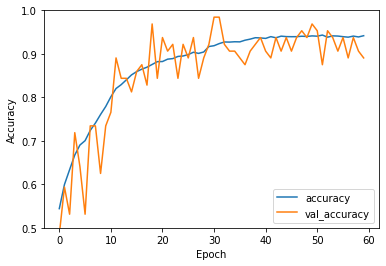

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()